In [1]:
# To check what all packages are installed
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
absolufy-imports                      0.3.1
accelerate                            1.10.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.7.2
arviz                                 0.22.0
astro

In [2]:
# Importing required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_datasets as tfds

import PIL.Image
import PIL.ImageColor
import PIL.ImageDraw
import PIL.ImageFont
import PIL.ImageOps

import os

In [3]:
# Visualisation Utilities
img_width =75
img_height =75
use_normalised_coordinates =True

In [4]:
def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=1, display_str_list=()):

  # Converts the input NumPy array (like the output from TensorFlow) into a PIL Image object
  image_pil = PIL.Image.fromarray(image)
  # Creates a new RGBA image (Red, Green, Blue, Alpha) of the same size as the input image
  rgbImg = PIL.Image.new("RGBA",image_pil.size)
  # Copies the original image into the new RGBA canvas.
  rgbImg.paste(image_pil)
  # Calls the next function to actually draw the bounding boxes surrounding the image
  draw_bounding_boxes_on_image(rgbImg, boxes, color, thickness, display_str_list)
  # Converts the PIL image back into a NumPy array to be used by Tensorflow
  return np.array(rgbImg)

def draw_bounding_boxes_on_image(image, boxes, color, thickness, display_str_list):
  # boxes -> 2-D array of shape [N,4] , N -> No of objects detected
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  # Ensures each box has 4 co ordinates
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    # order: boxes[i,1] -> x_min (left edge), boxes[i,0] -> y_min (top edge),
    #        boxes[i,3] -> x_max (right edge), boxes[i,2] -> y_max (bottom edge)

    draw_bounding_box_on_image(image, boxes[i,1],boxes[i,0],boxes[i,3],boxes[i,2],color[i],
                               thickness,display_str_list[i])

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color="red",thickness=1,use_normalised_coordinates=True):
  # Preparing drawing resources and waiting for actually start drawing
  draw = PIL.ImageDraw.Draw(image)
  # Image size (width: horizontal , height: verticle) in pixels
  img_width, img_height = image.size

  # Bounding box coordinates are normalized with values of 0 and 1
  # which are fractions of image width/height and are needed to be multiplied
  # by actual image size to get true pixel location

  # Example -> For 200 x 200 pixel space with 120 x 50 image
  # Model has -> ymin = 0.1 , xmin = 0.2 , ymax = 0.6 , xmax = 0.8 and
  # img_width = 200 , img_height = 200

  # Calculate True pixel location by xmin * img_width , ymin * img_height ,etc

  # Left-Top corner [Edge]     = (40, 10)
  # Right-Bottom corner [Edge] = (160, 60)


  if use_normalised_coordinates:
    (left, right, top, bottom) = (xmin * img_width, xmax * img_width,
                                  ymin * img_height, ymax * img_height)
  # Already in pixel value
  else:
    (left,right,top,bottom) = (xmin,xmax,ymin,ymax)

  # Drawing rectangle by connecting points [left-top to left bottom then to right bottom then ...]
  draw.line(
      [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
      width=thickness,
      fill=color
  )

In [5]:
# training_dataset   → TensorFlow dataset for training (images, labels, bboxes).
# validation_dataset → dataset for validation [Used during training to check how well the
#                                              model is doing on unseen data]
# N                  → number of samples (batch size) to extract.

# Goal -> Convert Tensorflow dataset into numpy array which is easier
#         for plotting and debugging

def dataset_to_numpy_util(training_dataset, validation_dataset, N):
    # unbatch() -> It would split dataset into indivisual elements (batch size =1)
    # batch().  -> It would group the dataset into batches of count N
    batch_train_ds = training_dataset.unbatch().batch(N)

    # To convert validation dataset and training dataset in NumPy format
    # The dataset has images, labels, bounding boxes
    # Only one batch dataset is taken as it has the entire validation dataset with N samples
    if tf.executing_eagerly():

        for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
            validation_digits = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes = validation_bboxes.numpy()
            break

        for training_digits, (training_labels, training_bboxes) in training_dataset:
            training_digits = training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes = training_bboxes.numpy()
            break

    #  Convert labels from One-Hot encoding [0 and 1 ] to class ID [Integers]

    # One-Hot Encoding & Class ID ->
    # Suppose we have 3 classes: cat [Class ID 1], dog [Class ID 2], bird [Class ID 3]
    # For class 'cat' , one-hot  would be [1, 0, 0] ;
    # For class 'dog' , one-hot  would be [0, 1, 0] ;
    # For class 'bird' , one-hot  would be [0, 0, 1] ;

    validation_labels = np.argmax(validation_labels, axis=1)
    training_labels = np.argmax(training_labels, axis=1)

    # Returing all 6 Numpy Arrays
    return (training_digits, training_labels, training_bboxes,
            validation_digits, validation_labels, validation_bboxes)


In [6]:
# Checking storage location of font
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# This function will create digit images (0–9, repeated up to n) using local fonts.
def create_digits_from_local_fonts(n):
    font_labels = []
    # LA = Luminance (grayscale) + Alpha (transparency).
    #Image size = 75*n width × 75 height → space for n digits.

    img = PIL.Image.new('LA', (75*n, 75), color=(0, 255))

    # Loading two fonts at size 25px
    font1 = PIL.ImageFont.truetype(
        os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25
    )
    font2 = PIL.ImageFont.truetype(
        os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25
    )


    # We are drawing an image showing images side by side
    d = PIL.ImageDraw.Draw(img)
    for i in range(n):
        font_labels.append(i % 10)
        d.text((7 + i*75, 0 if i < 10 else -4),
               str(i % 10),
               fill=(255, 255),
               font=font1 if i < 10 else font2)

    # Converting Image to Array
    font_digits = np.array(img.getdata(), np.float32)[:, 0] / 255.0
    # Reshaping into original image shape and spliting into n chunks and storing
    # them in array of stack
    font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits,[75,75*n]),n,axis=1
                                               ), axis = 0 )[n,75*75])

    # font_digits → numpy array containing the digit images.
    # font_labels → list of digit labels (0,1,2,...)
    return font_digits, font_labels


In [7]:
# The function picks 10 random digit images from our dataset, shows them in a row, draws true
# and predicted bounding boxes on each image, displays the predicted label, and
# highlights wrong predictions in red.
# It also shows the IoU (Intersection over Union) [how well predicted box matches the true box]


def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):
    # Picking up 10 random samples randomly
    n = 10 # change to '3' to display with only 3 digits in the space
    indexes = np.random.choice(len(predictions), size=n)

    # Getting the digits, predictions, and labels for just those 10 samples
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    # Safety check to prevent errors when some inputs are empty
    n_iou = []
    if len(iou) > 0:
        n_iou = iou[indexes]

    n_pred_bboxes = []
    if len(pred_bboxes) > 0:
        n_pred_bboxes = pred_bboxes[indexes]

    n_bboxes = []
    if len(bboxes) > 0:
        n_bboxes = bboxes[indexes]

    # Converting to greyscale values (0–255) to look like image
    n_digits = n_digits * 255.0
    # Reshaping digits into req pixels to fit in box of image
    n_digits = n_digits.reshape(n, 75, 75)

    # Making figure to show 10 images in a row
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

    # The entire figure is huge space and adding subplot would
    # show digits in multiple plots spreaded over the figure
    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1)
        bboxes_to_plot = []


        # Adding Predicted Bounding Boxes -> Red Colour
        # Adding True Bounding Boxes      -> Green Colour
        if len(n_pred_bboxes) > i:
            bboxes_to_plot.append(n_pred_bboxes[i])

        if len(n_bboxes) > i:
            bboxes_to_plot.append(n_bboxes[i])

        # Calling function to overlay bounding boxes on digit image
        img_to_draw = draw_bounding_boxes_on_image_array(
            image=n_digits[i],
            boxes=np.array(bboxes_to_plot),
            color=['red', 'green'],
            display_str_list=["True", "Pred"]
        )

        # Shows predicted digit under the image.
        plt.xlabel(n_predictions[i])
        plt.xticks([])
        plt.yticks([])

        # The label turns red (to highlight mistakes)
        if n_predictions[i] != n_labels[i]:
            ax.xaxis.label.set_color('red')

        # Displays the digit with bounding boxes.
        plt.imshow(img_to_draw)

        # Shows IoU score [IoU < 0.5, it’s considered bad overlap]
        if len(n_iou) > i:
            color = "black"
            if n_iou[i][0] < 0.5:  # example threshold
                color = "red"
            ax.text(0.2, -0.3, "iou: %s" % (n_iou[i][0]),
                    color=color, transform=ax.transAxes)


In [8]:
# To plot the Metrics -> To track the change in loss and accuracy and compare
#                        training vs validation performance to improve over epoch value
#  Training metric -> Blue , Validation metric -> Green

# metric_name → the name of the metric you want to plot eg-> 'loss' or 'accuracy'
# y-axis limit is set to 5
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)

    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)


In [9]:
# @title LOADING AND PRE PROCESSING DATASET


In [10]:
# Strategy for distributed training

# Distribute training data across multiple devices [CPUs, GPUs, TPUs (Tensor Processing Unit)]
# to train our model faster and more efficiently by distributing work
strategy = tf.distribute.get_strategy()

# Replica              -> Copy of model on one device
# num_replicas_in_sync -> tells you how many replicas are training data in sync at the same time
strategy.num_replicas_in_sync


1

In [11]:
# Batch size
BATCH_SIZE = 64

# If we want to make 2 GPU handle 128 global batches with each getting 64 batches
# BATCH_SIZE = 64 * strategy.num_replicas_in_sync



In [12]:
# Function to read and Preprocess image from TFDS
# The image is from MNIST [Modified National Institute of Standards and Technology dataset]
# It contains digit with image size 28x28 which is handwritten in grayscale [black and white]
def read_image_tfds(image, label):

    # Pick a random top-left corner (xmin, ymin) between 0 and 48 to place the image (digit)
    # in the 78x78 space
    xmin = tf.random.uniform((), 0, 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)

    # Placing the 28×28 digit inside a bigger 75×75 image, at position (xmin, ymin)
    image = tf.reshape(image, (28, 28, 1))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    # Converting image to float32 [neural network works better with float and not integers]
    # and normalize pixel values to [0, 1] we divide by 255.0 to increase efficiency of neural network
    image = tf.cast(image, tf.float32) / 255.0

    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)

    # Convert corner positions into normalized bounding box coordinates [btw 0 to 1]
    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75

    # label -> class number (integer) , 10 -> Total length of one-hot vector [0-9]
    # example -> tf.one_hot(7, 10) → [0,0,0,0,0,0,0,1,0,0]

    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])


In [13]:
# Training Dataset
def get_training_dataset():

    # Ensuring that all operations inside are distributed correctly across multiple
    # devices (GPU/TPU)
    with strategy.scope():
        # Loading MNIST dataset (60k images) , try_gcs=True -> allows downloading from Google Cloud
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
        # Applying function to all images
        # num_parallel_calls=16 → use 16 CPU threads in parallel to make processing faster
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        # 5000 samples are shuffled randomly
        # Each EPOCH is shuffled which is one complete pass through the entire training dataset by the model
        # More Epoch will increase the accuracy and decrease loss but too much epoch may
        # lead to overfitting (model memorizing instead of analysing)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat()
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(-1)
    return dataset


In [14]:
# Validation dataset (same process as above for validation dataset)
def get_validation_dataset():
    with strategy.scope():
        dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.batch(10000, drop_remainder=True)
        dataset = dataset.repeat()
    return dataset


In [15]:
# Create training and validation datasets
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.G9D89Z_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.G9D89Z_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [16]:
# Convert Dataset to numpy arrays for visualization
# Tensor Dataset is good for computation (GPU,TPU Processing) [training] but
# to visualise or debugging tensor dataset is converted to numpy array which
# can be easily passed on to matplot library
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(
    training_dataset, validation_dataset, 10
)


In [17]:
# @title VISUALISING DATA


In [18]:
# Training set → Data the model studies and learns from (like class notes)

# Validation set → Data used during training to check how well the model is
# learning (like practice tests)

# Test set → Data used only at the end to see final performance (like the final exam)

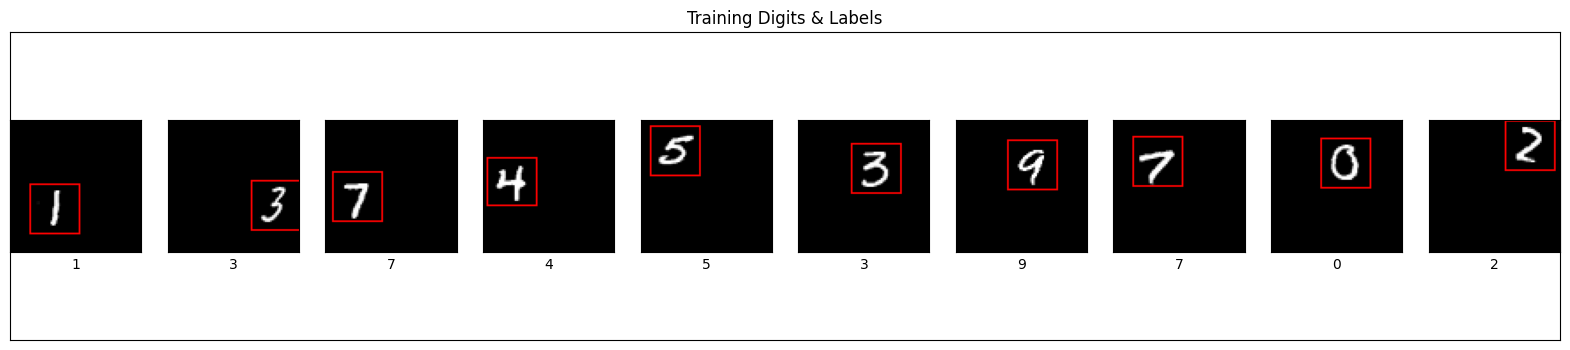

In [19]:
# Visualize TRAINING digits with bounding boxes
display_digits_with_boxes(
    training_digits, training_labels,
    training_labels, np.array([]),
    training_bboxes, np.array([]),
    "Training Digits & Labels"
)

# Predicted Bounding Boxes -> Red Colour
# True Bounding Boxes      -> Green Colour

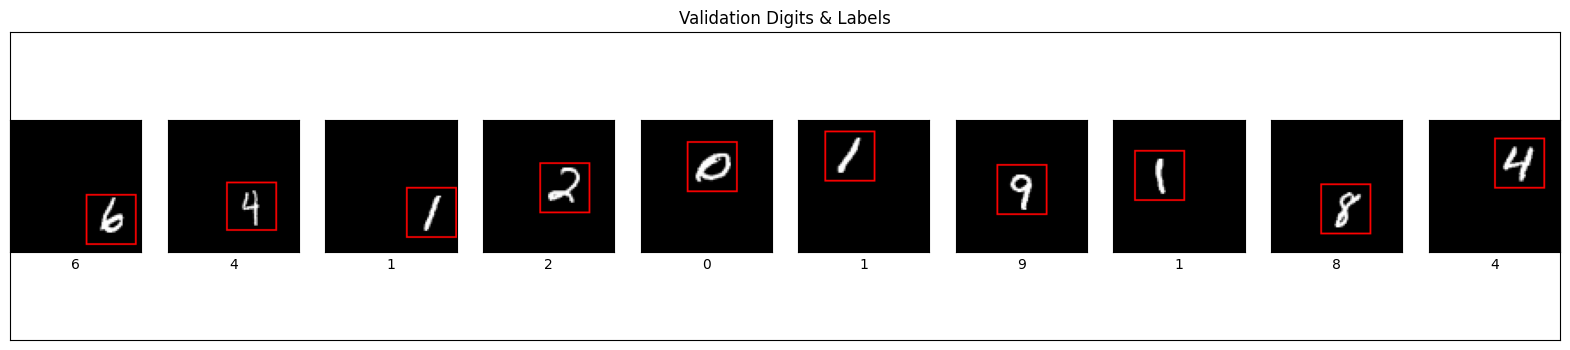

In [20]:
# Visualize VALIDATION digits with bounding boxes
display_digits_with_boxes(
    validation_digits, validation_labels,
    validation_labels, np.array([]),
    validation_bboxes, np.array([]),
    "Validation Digits & Labels"
)

# Predicted Bounding Boxes -> Red Colour
# True Bounding Boxes      -> Green Colour

In [21]:
# @title DEFINE THE NETWORK


In [22]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75,75,1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(32, activation='relu', kernel_size=3)(x)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3)(x)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    return x


In [23]:
def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return x


In [24]:
def classifier(inputs):
    classification_output = tf.keras.layers.Dense(10, activation="softmax", name="classification")(inputs)
    return classification_output


In [25]:
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(4, name="bounding_box")(inputs)
    return bounding_box_regression_output


In [26]:
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs=inputs, outputs=[classification_output, bounding_box_output])
    return model


In [27]:
def define_and_compile_model(inputs):
    model = final_model(inputs)

    model.compile(
        optimizer='adam',
        loss={
            'classification': 'categorical_crossentropy',
            'bounding_box': 'mse'
        },
        metrics={
            'classification': 'accuracy',
            'bounding_box': 'mse'
        }
    )
    return model


In [28]:
with strategy.scope():
    inputs = tf.keras.layers.Input(shape=(75,75,1))
    model = define_and_compile_model(inputs)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 36, 36,    │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 17, 17,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 7, 7, 64)  │          0 │ conv2d_2[0][0]    │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 10)        │      1,290 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bounding_box        │ (None, 4)         │        516 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 426,638 (1.63 MB)

 Trainable params: 426,638 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# @title TRAIN AND VALIDATE THE MODEL


In [31]:

EPOCHS = 20

# Total samples (60k) / batch size
# [60,000 samples are necessary for High Accuracy and Optimised result]
steps_per_epoch = 60000 // BATCH_SIZE

# Train the model
history = model.fit(
    training_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=1,
    epochs=EPOCHS
)

# Evaluate the model
loss, classification_loss, bounding_box_loss, classification_acc, bounding_box_mse = model.evaluate(
    validation_dataset,
    steps=1
)

print("\n-------------------------------\n")
print("Validation Accuracy: ", classification_acc)
print("\n-------------------------------\n")


Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 450ms/step - bounding_box_loss: 0.0161 - bounding_box_mse: 0.0161 - classification_accuracy: 0.8471 - classification_loss: 0.4966 - loss: 0.5127 - val_bounding_box_loss: 0.0176 - val_bounding_box_mse: 0.0176 - val_classification_accuracy: 0.8444 - val_classification_loss: 0.4936 - val_loss: 0.5112
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step - bounding_box_loss: 0.0137 - bounding_box_mse: 0.0137 - classification_accuracy: 0.8592 - classification_loss: 0.4461 - loss: 0.4598 - val_bounding_box_loss: 0.0124 - val_bounding_box_mse: 0.0124 - val_classification_accuracy: 0.8764 - val_classification_loss: 0.3975 - val_loss: 0.4099
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 402ms/step - bounding_box_loss: 0.0113 - bounding_box_mse: 0.0113 - classification_accuracy: 0.8788 - classification_loss: 0.4032 - loss: 0.4145 - val_bounding_box_loss: 0.0091 - val_bounding_box_mse: 0.0091 - val_classification_accuracy: 0.9087 - val_classification_loss: 0.3

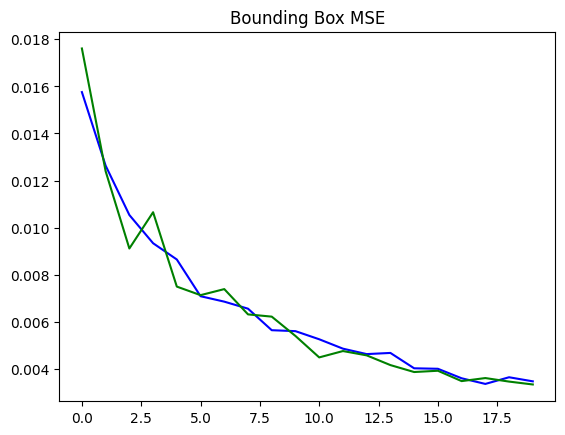

In [32]:
plot_metrics("bounding_box_mse", "Bounding Box MSE")

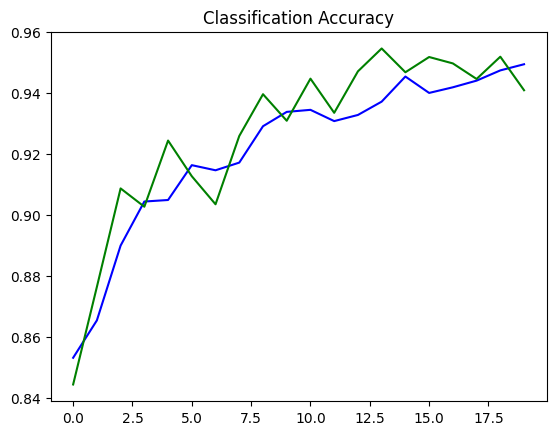

In [33]:
plot_metrics("classification_accuracy", "Classification Accuracy")

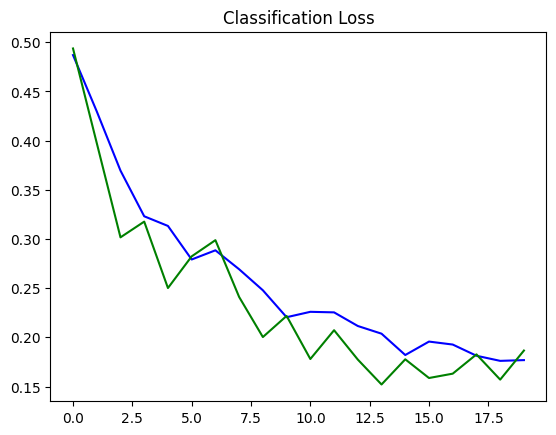

In [34]:
plot_metrics("classification_loss", "Classification Loss")

In [35]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis=1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis=1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0) * \
                   np.maximum((ymax_overlap - ymin_overlap), 0)

    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou


In [36]:
prediction = model.predict(validation_digits, batch_size=64)

predicted_labels = np.argmax(prediction[0], axis=1)

prediction_bboxes = prediction[1]


157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step


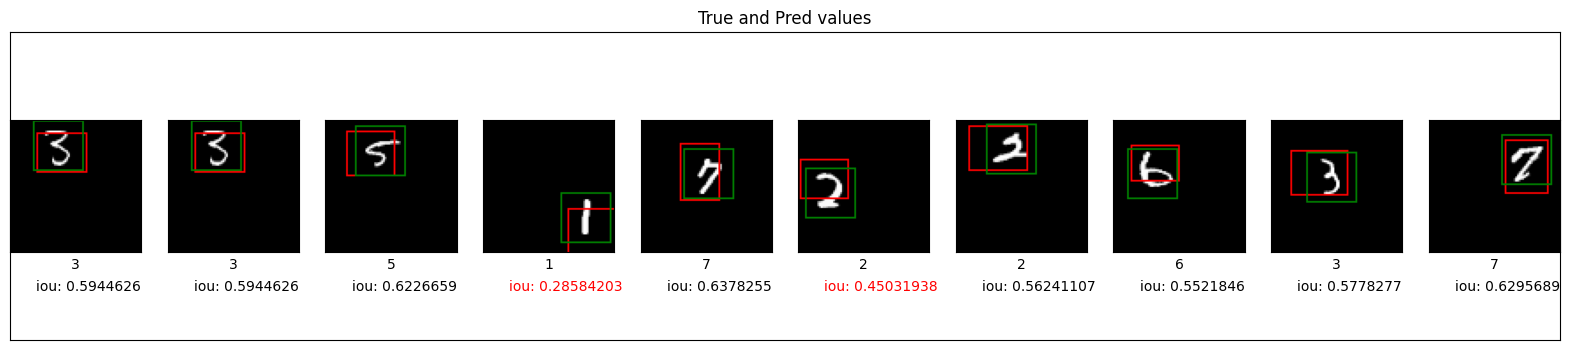

In [37]:
iou = intersection_over_union(prediction_bboxes, validation_bboxes)

iou_threshold = 0.6

# Dislaying with n=10 (10 digits)
display_digits_with_boxes(
    validation_digits,
    predicted_labels,
    validation_labels,
    prediction_bboxes,
    validation_bboxes,
    iou,
    "True and Pred values"
)


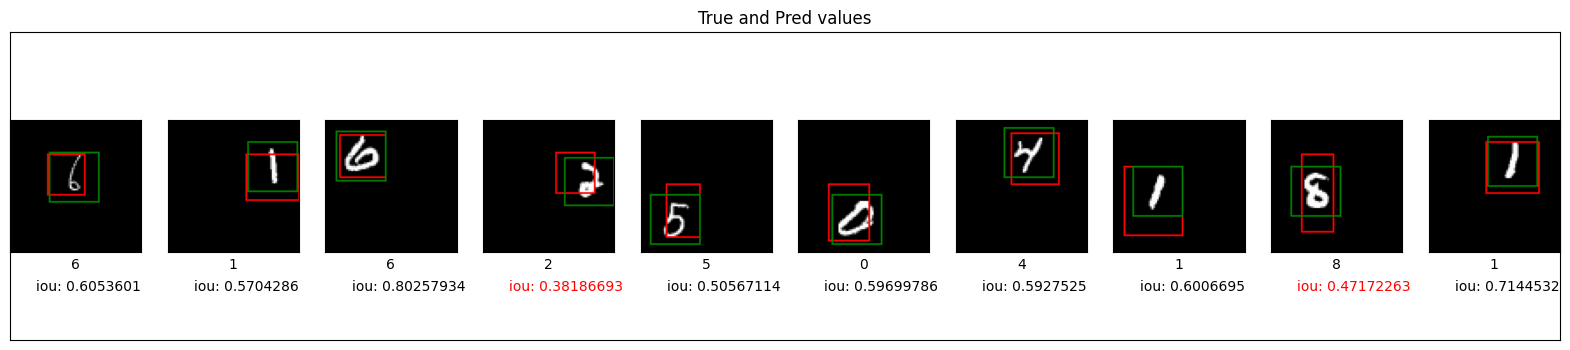

In [38]:
# Dislaying with n=3 (3 digits) [change function : display_digits_with_boxes]
display_digits_with_boxes(
    validation_digits,
    predicted_labels,
    validation_labels,
    prediction_bboxes,
    validation_bboxes,
    iou,
    "True and Pred values"
)
